<a href="https://colab.research.google.com/github/unknopu/AI-Pacman/blob/main/test_MAD_lab_module1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Predictive model

Credit card usage prediction

**Objective**

Our goal is to develop a *regression model* that forecasts the *transaction amount* for each credit card in the *upcoming month*.







## 1.0 Download dataset

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import requests
from io import BytesIO
from zipfile import ZipFile

from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error

from datetime import date

In [ ]:
!kaggle datasets download -d iabhishekofficial/creditcard-fraud-detection

In [ ]:
!unzip creditcard-fraud-detection.zip

In [ ]:
df_info = pd.read_csv('cc_info.csv')
df_txn = pd.read_csv('transactions.csv')
df_txn['date'] = pd.to_datetime(df_txn['date'])

## 1.1 Data visualization​


### 1.1.1 Please display the first 10 rows of  ```df_info``` you read from above cell


In [ ]:
#### YOUR CODE IS HERE ####

###########################

### 1.1.2 Visualize the distribution of the ```credit_card_limit``` column from ```df_info```.



In [ ]:
#### YOUR CODE IS HERE ####

###########################

### 1.1.3 Visualize the relationship between ```state``` and average ```credit card limit``` as a bar chart from ```df_info```

In [ ]:
#### YOUR CODE IS HERE ####

###########################

### 1.1.4 Which month and day has the highest transaction amount? and what is the total transaction amount for that day?

In [ ]:
#### YOUR CODE IS HERE ####

###########################

In [ ]:
#### ANSWER IS HERE ####
answer_date = pd.to_datetime('1999-12-31') # edit here
answer_total_txn = None # edit here
###########################

In [ ]:
# JUST RUN
print(f'target month is {answer_date.month} and target day is {answer_date.day}' )
print(f'total transaction equal {answer_total_txn}')

## 1.2 Data preparation​

### We will build monthly features as a DataFrame with the following columns:

1.   `credit_card` [Primary key]
2.   `feat_dt` [Primary key]

**Example:**

|credit_card|feat_dt |sum_amt_l1w	|sum_amt_l2w	|sum_amt_l4w	|count_txn_l1w	|count_txn_l2w	|count_txn_l4w	|pct_usage	|avg_long	|avg_lat|
|----|----|----|----|----|----|----|----|----|----|----|
|1003715054175576| 2015-08-31| 2848.51| 4280.81| 5852.26| 23.0| 38.0| 58.0| 39.43| -80.220597| 40.240542|
|1013870087888817	|2015-08-31	|3062.95	|6577.99	|8448.33		|28.0	|55.0	|75.0	|74.525800|	 -72.093032	|43.163705
|1023820165155391	|2015-08-31	|5810.16	|12283.20	|15327.74	|50.0	|96.0	|138.0	|78.105179|	 -73.234400	|44.312872


### We build label as Total transaction along next week


In [ ]:
# JUST RUN
def gen_label(feat_dt, txn):
  txn['tmp_date'] = feat_dt
  txn['tmp_date'] = pd.to_datetime(txn['tmp_date'])
  txn['day_diff'] = (txn['date']-txn['tmp_date']).dt.days
  label = txn[txn['day_diff'].between(1, 7)].groupby('credit_card').agg(sum_amt_label=('transaction_dollar_amount', 'sum')).reset_index()
  label['sum_amt_label'] = label['sum_amt_label'].fillna(0)
  label['feat_dt'] = feat_dt
  return label

### 1.2.1 Build Monthly Features - Sum Amount

1. Sum of amount in the last 1 week (7 days)
2. Sum of amount in the last 2 weeks (14 days)
3. Sum of amount in the last 4 weeks (28 days)

For example, for a credit card with a feature date of `2022-07-28`, you would calculate the sum of transaction amounts from:

* `2022-07-22` to `2022-07-28` (7 days)
* `2022-07-15` to `2022-07-28` (14 days)
* `2022-07-01` to `2022-07-28` (28 days)

**Example:**

|credit_card      | feat_dt     | sum_amt_l1w | sum_amt_l2w | sum_amt_l4w|
|----|----|----|----|----|
| 1003715054175576 | 2015-10-31  | 20000       | 500000      | 1212123|





In [ ]:
# JUST RUN
def gen_feat_sum_amount(feat_dt, txn):
  txn['tmp_date'] = feat_dt
  txn['tmp_date'] = pd.to_datetime(txn['tmp_date'])
  txn['day_diff'] = (txn['tmp_date']-txn['date']).dt.days
  feat_1 = txn[txn['day_diff'].between(0, 7)].groupby('credit_card').agg(sum_amt_l1w=('transaction_dollar_amount', 'sum')).reset_index()
  feat_2 = txn[txn['day_diff'].between(0, 14)].groupby('credit_card').agg(sum_amt_l2w=('transaction_dollar_amount', 'sum')).reset_index()
  feat_3 = txn[txn['day_diff'].between(0, 28)].groupby('credit_card').agg(sum_amt_l4w=('transaction_dollar_amount', 'sum')).reset_index()
  feat_sum_amt = feat_1.merge(feat_2, on='credit_card', how='outer').merge(feat_3, on='credit_card', how='outer')
  feat_sum_amt['feat_dt'] = feat_dt
  feat_sum_amt = feat_sum_amt.fillna(0)
  return feat_sum_amt

### 1.2.2 Build Monthly Features - Count Transactions

4. Count of transactions in the last 1 week (7 days)
5. Count of transactions in the last 2 weeks (14 days)
6. Count of transactions in the last 4 weeks (28 days)

For example, for a credit card with a feature date of `2022-07-28`, you would count the number of transactions from:

* `2022-07-22` to `2022-07-28` (7 days)
* `2022-07-15` to `2022-07-28` (14 days)
* `2022-07-01` to `2022-07-28` (28 days)

**Example:**

|credit_card      | feat_dt     | count_txn_l1w | count_txn_l2w | count_txn_l4w|
|----|----|----|----|----|
| 1003715054175576 | 2015-10-31  | 5            | 10            | 50




In [ ]:
def gen_feat_count_txn(feat_dt, txn):
  txn['tmp_date'] = feat_dt
  txn['tmp_date'] = pd.to_datetime(txn['tmp_date'])
  txn['day_diff'] = (txn['tmp_date']-txn['date']).dt.days

  #### YOUR CODE IS HERE ####

  ###########################

  return feat_count_txn # final dataframe is feat_count_txn

### 1.2.3 Build Monthly Features - Percent Usage

7. `percent_usage` is calculated as follows:
$$\textrm{percent_usage} = \displaystyle{\frac{\textrm{sum_amount_last_4_weeks} \times 100}{\textrm{credit_limit}}}$$

**Example:**

|credit_card      | feat_dt     | pct_usage |
|----|----|----|
| 1003715054175576 | 2015-10-31  | 20.12  |




In [ ]:
## build monthly features - percent usage
## percent usage = monthly_sum_amount * 100 / credit_limit

def gen_feat_usage(feat_dt, txn, card_info):
  txn['tmp_date'] = feat_dt
  txn['tmp_date'] = pd.to_datetime(txn['tmp_date'])
  txn['day_diff'] = (txn['tmp_date']-txn['date']).dt.days
  feat_1 = txn[txn['day_diff'].between(0, 28)].groupby('credit_card').agg(sum_amt_l1m=('transaction_dollar_amount', 'sum')).reset_index()
  feat_sum_amt = feat_1.fillna(0)
  feat_sum_amt['feat_dt'] = feat_dt
  feat_pct_usage = feat_sum_amt.merge(card_info[['credit_card', 'credit_card_limit']], on='credit_card')

  #### YOUR CODE IS HERE ####

  ###########################

  return feat_pct_usage # final dataframe is feat_pct_usage

### 1.2.4 Build Monthly Features - Find Average Long, Average Lat of Each Card in Each Month

8. `average(p10, p90) avg long`
9. `average(p10, p90) avg lat`

*Hint: You should remove outliers (lat, long). Why?*

For example, if you purchase 1 item in the USA and 10 items in Thailand, the average location without removing outliers might incorrectly indicate Japan (which could be irrelevant).

**Example:**

|credit_card      | feat_dt     | avg_long  | avg_lat  |
|----|----|----|----|
| 1003715054175576 | 2015-10-31  |  -80       | 40       |

In [ ]:
def remove_and_mean(data):
  if len(data)>=3:
    p10 = np.percentile(data, q=10)
    p90 = np.percentile(data, q=90)
    data_remove_outlier = [e for e in data if p10<=e<=p90]
  else:
    data_remove_outlier = data
  return np.mean(data_remove_outlier)

def gen_feat_average_latlong(feat_dt, txn):
  txn['tmp_date'] = feat_dt
  txn['tmp_date'] = pd.to_datetime(txn['tmp_date'])
  txn['day_diff'] = (txn['tmp_date']-txn['date']).dt.days

  #### YOUR CODE IS HERE ####

  ###########################

  return feat_average_latlong

### 1.2.5 Build monthly features - combine all features and label.

In [ ]:
# JUST RUN
def gen_feat_label(feat_dt, txn):

  f1 = gen_feat_sum_amount(feat_dt, txn)
  f2 = gen_feat_count_txn(feat_dt, txn)
  f3 = gen_feat_usage(feat_dt, txn, df_info)
  f4 = gen_feat_average_latlong(feat_dt, txn)
  all_feat = f1.merge(
      f2, on=['credit_card', 'feat_dt'], how='outer'
  ).merge(
      f3, on=['credit_card', 'feat_dt'], how='outer'
  ).merge(
      f4, on=['credit_card', 'feat_dt'], how='outer'
  )

  label = gen_label(feat_dt, txn)
  all_feat = all_feat.merge(label, on=['credit_card', 'feat_dt'], how='outer')

  return all_feat[[
      'credit_card', 'feat_dt',
      'sum_amt_l1w', 'sum_amt_l2w', 'sum_amt_l4w',
      'count_txn_l1w', 'count_txn_l2w', 'count_txn_l4w',
      'pct_usage',
      'avg_long', 'avg_lat','sum_amt_label']]


x1 = gen_feat_label(feat_dt=date(2015, 8, 31), txn=df_txn)
x2 = gen_feat_label(feat_dt=date(2015, 9, 7), txn=df_txn)
x3 = gen_feat_label(feat_dt=date(2015, 9, 14), txn=df_txn)
x4 = gen_feat_label(feat_dt=date(2015, 9, 21), txn=df_txn)
x5 = gen_feat_label(feat_dt=date(2015, 9, 28), txn=df_txn)
x6 = gen_feat_label(feat_dt=date(2015, 10, 7), txn=df_txn)
x7 = gen_feat_label(feat_dt=date(2015, 10, 14), txn=df_txn)
x8 = gen_feat_label(feat_dt=date(2015, 10, 21), txn=df_txn)
x9 = gen_feat_label(feat_dt=date(2015, 10, 28), txn=df_txn)


df_final = pd.concat([x1, x2, x3, x4, x5, x6, x7, x8, x9])

df_final['sum_amt_label'] = df_final['sum_amt_label'].fillna(0)
df_final = df_final.reset_index(drop=True)

## 1.3 Model pipeline and evaluation metrics

### 1.3.1 Create `df_train`, `df_val`, and `df_test` Following the Criteria

1. `df_train`:\
   `feat_dt` between `2015-08-31` and `2015-09-28` (inclusive)
2. `df_val`:\
   `feat_dt` are `2015-10-07` and `2015-10-14`
3. `df_test`:\
   `feat_dt` are `2021-10-21` and `2015-10-28`







In [ ]:
def prep_train_val_test(df_final):
  #### YOUR CODE IS HERE ####

  ###########################
  return df_train, df_val, df_test

In [ ]:
df_train,df_val, df_test = prep_train_val_test(df_final)

### 1.3.2 Prepare `X` and `y` from Training, Validation, and Test Sets Following the Criteria

1. `X` comes from the columns:

       'sum_amt_l1w', 'sum_amt_l2w', 'sum_amt_l4w',
       'count_txn_l1w', 'count_txn_l2w', 'count_txn_l4w',
       'pct_usage', 'avg_long', 'avg_lat'

  After selecting the above columns, fill null values with 0 for all features.

2. `y` comes from the column `sum_amt_label`.

In [ ]:
def prep_X_y(df):

  #### YOUR CODE IS HERE ####


  ###########################

  return X,y

In [ ]:
X_train,y_train = prep_X_y(df_train)
X_val,y_val = prep_X_y(df_val)
X_test,y_test = prep_X_y(df_test)

### 1.3.3 Create Lasso Regression Model Using

1. **Lasso Regression**
   - Library: `sklearn.linear_model`

2. **Inputs**
   - `X` is the feature set
   - `y` is the label set
   - `alpha` is a hyperparameter in the Lasso model

3. **Output**
   - `lasso` model

In [ ]:
def create_lasso_model(X, y, alpha):

  #### YOUR CODE IS HERE ####


  ###########################

  return lasso

In [ ]:
# JUST RUN
# Create scaler using min-max scaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

lasso = create_lasso_model(X_train_scaled, y_train,alpha=1.0)
y_test_pred = lasso.predict(X_test_scaled)

# Performance of this model
mse_lasso = mean_squared_error(y_test, y_test_pred)
mae_lasso = mean_absolute_error(y_test, y_test_pred)
print("\nRidge Regression Model Performance:")
print(f"Mean Squared Error: {mse_lasso}")
print(f"Mean Absolute Error: {mae_lasso}")

### 1.3.4 Show Scatter Plot Between `y_test` and `y_test_pred`

1. The x-axis represents `y_test`.
2. The y-axis represents `y_test_pred`.

In [ ]:
#### YOUR CODE IS HERE ####


###########################

plt.plot([min(y_test), max(y_test)], [min(y_test_pred), max(y_test_pred)], linestyle='--', color='red')
plt.show()

### Lasso regression with hyperparameter tuning

In [ ]:
# JUST RUN

from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Define a range of alpha values to try
alpha_values = [0.01,0.1,0.6,0.8,1,1.2,1.4,1.6,2,4,5,10,100]

# Initialize variables to store the best alpha and its corresponding performance
best_alpha = None
best_mse = np.inf  # Start with a large value for MSE

# Loop through the different alpha values
for alpha in alpha_values:
    # Create and train the Ridge Regression model
    model = create_lasso_model(X_train_scaled, y_train, alpha)

    # Predict on the validation set
    y_val_pred = model.predict(X_val_scaled)

    # Calculate the Mean Squared Error on the validation set
    mse_val = mean_squared_error(y_val, y_val_pred)
    print(f"Alpha: {alpha}, Validation MSE: {mse_val:.4f}")

    # Check if this is the best performance so far
    if mse_val < best_mse:
        best_mse = mse_val
        best_alpha = alpha

# Print the best alpha and its corresponding MSE
print(f"\nBest alpha: {best_alpha}")
print(f"Best Validation MSE: {best_mse:.4f}")

# Train the final model using the best alpha value
final_model = create_lasso_model(X_train_scaled, y_train, best_alpha)

print(f"------------------------------------------------")


### 1.3.5 After Tuning the Model Using Hyperparameter Tuning, What Are the Mean Squared Error and Mean Absolute Error of This Model?

*Hint: Calculate metrics based on `X_test_scaled` and `y_test`.*

In [ ]:
def get_mean_squared_error(model, X, y):
  #### YOUR CODE IS HERE ####

  ###########################
  return mse

def get_mean_absolute_error(model, X, y):
  #### YOUR CODE IS HERE ####

  ###########################
  return mae

mse_lasso_final = get_mean_squared_error(final_model, X_test_scaled, y_test)
mae_lasso_final = get_mean_absolute_error(final_model, X_test_scaled, y_test)

print("\nRidge Regression Model Performance:")
print(f"Mean Squared Error: {mse_lasso_final}")
print(f"Mean Absolute Error: {mae_lasso_final}")

### 1.3.6 Which model is better? first model or final_model

In [ ]:
#### YOUR CODE IS HERE (OPTIONAL) ####


####################################

In [ ]:
## YOUR ANSWER HERE ##
# 'first model' if the first model is better.
# 'final model' if the last model is better.
answer = None
print(f'{answer} is better')

######################

---


# 2. Time Series Analysis



In [ ]:
!pip install pmdarima

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error

## 2.0 Download dataset

In this lab, we will use the monthly Electricity Production data from Kaggle.

https://www.kaggle.com/datasets/shenba/time-series-datasets/data?select=Electric_Production.csv

In [ ]:
!kaggle datasets download -d shenba/time-series-datasets
!unzip time-series-datasets.zip -d time_series_dataset
!rm time-series-datasets.zip

In [ ]:
df = pd.read_csv('time_series_dataset/Electric_Production.csv')
df = df.rename({
    'DATE': 'Date',
    'IPG2211A2N': 'Production'
}, axis=1)
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
df = df.set_index('Date')

data = df['Production']

After reading the time series data from the CSV file, we did some formatting so that our `data` is a Pandas Series with Date as its index, as shown below.

In [ ]:
data

## 2.1 Hands-On with `auto_arima` for ARIMA Parameter Selection

In the lecture, we introduced a tool for identifying the appropriate parameters for ARIMA models: `auto_arima` from the pmdarima library.

For detailed documentation, you can refer to the pmdarima `auto_arima` [documentation](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html).

In this lab, you will gain hands-on experience using `auto_arima` to simplify the process of selecting ARIMA parameters. We will also explore the importance of the seasonal component in SARIMA models.

In [ ]:
import pmdarima as pm

### 2.1.1 Train-Test Data Splitting

First, we need to slice our `data` to select a portion of the dataset and split it into training and test sets. Your task is to apply slicing to `data` so that `train_data` includes data from **January 2001 to December 2014**, while `test_data` includes data from **January 2015 to December 2017**.

In [ ]:
### YOUR CODE HERE ###
train_data = None
test_data = None
######################

### 2.1.2 Plotting Training and Test Data

Your task is to implement the `plot_train_test` function that meets the following requirements:

* The function should plot `train_data` and `test_data` on the same figure.
* `train_data` and `test_data` should be plotted in different colors, with a legend indicating which color represents each dataset.
* The x-axis should display the corresponding dates and be labeled "Date".
* The y-axis should be labeled "Electricity Production".

**Hint:** Since our data is a Pandas Series, you can use the `pandas.Series.plot` function to make plotting more convenient. Check the [documentation](https://pandas.pydata.org/docs/reference/api/pandas.Series.plot.html) for additional details.

**Note:** Do not include `plt.show()` in the function. It will be called separately after the function is executed.


In [ ]:
def plot_train_test(train_data, test_data):
    ### YOUR CODE HERE ###






    ######################

In [ ]:
plot_train_test(train_data, test_data)
plt.show()

### 2.1.3 Adding Predictions to the Plot

We will prepare another plotting function to be used after we complete the forecasting task in 2.1.4. Your task is to implement the `plot_train_test_pred` function, which is similar to the function you implemented in task 2.1.2. Follow the steps below:

1. Copy the code from your `plot_train_test` function into the `plot_train_test_pred` function.
2. Plot `prediction` on the same figure. Ensure that `prediction` is plotted in a different color and include it in the legend.

**Note:** Do not include `plt.show()` in the function. It will be called separately after the function is executed.


In [ ]:
def plot_train_test_pred(train_data, test_data, prediction):
    ### YOUR CODE HERE ###







    ######################

### 2.1.4 Fitting Non-Seasonal ARIMA Model and Forecasting

Next, we will use the `auto_arima` function to fit non-seasonal ARIMA models and find the best parameters for our training data. Your task is to complete the following steps:

1. Use the `auto_arima` function to fit ARIMA models and find the best parameters for our `train_data`. Store the result in `arima`.
   * For now, you do not need to consider seasonality. Configure the function to only consider non-seasonal ARIMA models.
   * Set the `trace` parameter to `True` to visualize the process of the best parameters search done by `auto_arima`.
   * If you consult the documentation for `auto_arima`, you might encounter many other parameters not discussed in the lecture. **You do not need to consider these advanced parameters**—only use the parameters mentioned in the lecture slides.

2. Use the `arima` model from the previous step to forecast the test data (i.e., out-of-sample prediction). Ensure that the prediction length matches the length of the test data. Store the forecasted values in `prediction`.

**Hint:** Revisit the lecture slides or the [documentation](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html) for guidance on how to use the function.

**Note:** The `auto_arima` function supports inputting a Pandas series, so you can directly use our data with the function. If done correctly, your `prediction` will also be a Pandas series with the correct date index.

Also, verify that `plot_train_test_pred` is functioning as expected. If not, revisit and modify your code from task 2.1.3.

In [ ]:
### YOUR CODE HERE ###
arima = None
prediction = None
######################

plot_train_test_pred(train_data, test_data, prediction)
plt.show()

### 2.1.5 Finding the Seasonal Period

In contrast to task 2.1.4, where we did not consider seasonality, you might observe that the data contains some seasonal patterns. In this task, you will find the seasonal period of the seasonal pattern in our data. Follow the steps below:

1. Plot `train_data`, but this time only from **January 2012 to December 2014**. This will help you clearly observe how long it takes for the seasonal pattern to repeat.

   **Hint:** Observe the regular intervals at which similar patterns (such as peaks) repeat. This interval will indicate the length of the seasonal period.


2. Set `seasonal_period` as the seasonal period of the observed seasonal pattern.

   **Hint:** Determine how many time steps correspond to the interval you observed in step 1 to find the seasonal period. Recall that our data is **monthly** data.


In [ ]:
# Plot train_data from Jan 2012 to Dec 2014

### YOUR CODE HERE ###




######################

plt.show()

# Determine the seasonal period

### YOUR CODE HERE ###
seasonal_period = None
######################

### 2.1.6 Fitting Seasonal ARIMA Model and Forecasting

In this task, you will repeat the process from task 2.1.4, but now incorporating seasonality identified in task 2.1.5. Follow these steps:

1. Use the `auto_arima` function to fit a seasonal ARIMA model to the training data, including the seasonal pattern you determined. Store the result in `arima_seasonal`.
   * Configure the function to account for seasonality using the seasonal period from task 2.1.5.
   * Set the `trace` parameter to `True` to visualize the process of finding the best parameters.
   * The parameters covered in the lecture slides are sufficient to complete this task.

2. Use the `arima_seasonal` model from the previous step to forecast the test data (i.e., out-of-sample prediction). Ensure that the prediction length matches the length of the test data. Store the forecasted values in `prediction_seasonal`.


In [ ]:
### YOUR CODE HERE ###
arima_seasonal = None
prediction_seasonal = None
######################

plot_train_test_pred(train_data, test_data, prediction_seasonal)

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plot_train_test_pred(train_data, test_data, prediction)

arima_params = arima.get_params()
plt.title("Non-Seasonal ARIMA - $ARIMA{pdq}{PDQ}_{m}$".format(
    pdq=arima_params['order'],
    PDQ=arima_params['seasonal_order'][:3],
    m=arima_params['seasonal_order'][3]
))

plt.subplot(1, 2, 2)
plot_train_test_pred(train_data, test_data, prediction_seasonal)

arima_seasonal_params = arima_seasonal.get_params()
plt.title("Seasonal ARIMA - $ARIMA{pdq}{PDQ}_{m}$".format(
    pdq=arima_seasonal_params['order'],
    PDQ=arima_seasonal_params['seasonal_order'][:3],
    m=arima_seasonal_params['seasonal_order'][3]
))

plt.show()

From the comparison above, we observe that the non-seasonal ARIMA model can indeed capture some aspects of seasonality, but it requires a higher number of lags compared to the seasonal ARIMA model.

**Note:** A "lag" refers to the time steps in the past that the model uses to predict future values. In this case, if the previous tasks are done correctly, you will be able to see that the non-seasonal ARIMA model uses a higher number of autoregressive terms (the parameter $p$ of ARIMA) compared to the seasonal ARIMA model.

However, the seasonal ARIMA model more effectively captures the seasonal patterns, resulting in predictions that are closer to the actual test data. This underlines the significance of incorporating the seasonal component in ARIMA models when such patterns are present in the data.

While we have made a qualitative comparison by examining the two graphs, we can also validate our conclusion quantitatively. Below, we compare the Root Mean Square Error (RMSE) between the prediction and the actual test data. If the previous tasks are done correctly, the RMSE for the seasonal ARIMA model should be lower, meaning that its predictions are closer to the actual test data.

In [ ]:
print("RMSE for non-seasonal ARIMA: {:.4f}".format(mean_squared_error(test_data, prediction, squared=False)))
print("RMSE for seasonal ARIMA: {:.4f}".format(mean_squared_error(test_data, prediction_seasonal, squared=False)))

## 2.2 Preparing Data for One-Step-Ahead Prediction with LSTM *(Optional)*

Apart from ARIMA models, we briefly discussed using Long Short-Term Memory (LSTM) for time series forecasting in the lecture. In this section, you'll get a glimpse of how to work with LSTM. Since we haven't covered LSTM training in detail, your task here will focus on preparing the data for LSTM.

Unlike in problem 2.1, where we performed multi-step-ahead predictions—forecasting multiple future values at once—problem 2.2 will involve one-step-ahead predictions, where we forecast only the next time step.

To clarify the difference between multi-step-ahead and one-step-ahead predictions, consider the following distinctions:
* In problem 2.1, the ARIMA model was trained on data from January 2001 to December 2014, and we used it to predict the entire test set from January 2015 to December 2017 without the model ever encountering any actual data from the test range. This approach is an example of multi-step-ahead prediction.
* In problem 2.2, when making predictions on the test set, the LSTM model will predict one time step at a time. For instance, if we use the data from the previous 5 months to predict the value for the next month, we would input the actual data from January to May 2015 into the model, and it would predict June 2015. We would then input the actual data from February to June 2015, and the model would predict July 2015, and so on. This is how one-step-ahead prediction works.

Since this is your first introduction to LSTM, we'll keep it simple by focusing on one-step-ahead prediction.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input

### 2.2.1 Train-Val-Test Data Splitting

Just like in problem 2.1, we'll start by splitting our data into training and test sets. However, this time we will also create a validation set. Follow the steps below:

* Slice `data` so that `train_data_series` includes data from **January 1991 to December 2011**, `val_data_series` includes data from **January 2012 to December 2014**, and `test_data_series` includes data from **January 2015 to December 2017**. Ensure that `train_data_series`, `val_data_series`, and `test_data_series` remain as Pandas Series.
* Convert `train_data_series`, `val_data_series`, and `test_data_series` to NumPy arrays, naming them `train_data`, `val_data`, and `test_data`, respectively.


In [ ]:
# Slice data to split into training, validation, and test set

### YOUR CODE HERE ###
train_data_series = None
val_data_series = None
test_data_series = None
######################

# Convert to NumPy arrays

### YOUR CODE HERE ###
train_data = None
val_data = None
test_data = None
######################

### 2.2.2 Plotting Training, Validation, and Test Data

Similar to problem 2.1, you need to plot the split dataset on a single figure. Implement the `plot_train_val_test` function to meet the following criteria:

* The function should plot `train_data`, `val_data`, and `test_data` on the same figure, using different colors for each dataset. Remember to include a legend to identify each dataset.
* Since we are working with NumPy arrays, not Pandas Series, ignore the dates and use time steps for the x-axis instead.
* Note that each dataset starts at a different time step. The training set should begin at time step 0, followed by the validation set, and then the test set.
* Label the x-axis as "Time Step".
* Label the y-axis as "Electricity Production".

**Note:** Do not include `plt.show()` in the function. It will be called separately after the function is executed.

To avoid confusion about the time steps, refer to the example result provided.

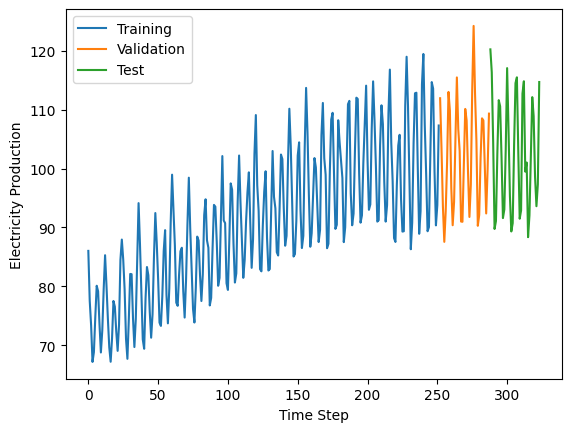

In [ ]:
def plot_train_val_test(train_data, val_data, test_data):
    ### YOUR CODE HERE ###







    ######################

In [ ]:
plot_train_val_test(train_data, val_data, test_data)
plt.show()

### 2.2.3 Implementing a Custom Min-Max Scaler

When using LSTM, it is a good practice to rescale the data to a smaller range. A common approach is to scale data to the range of 0-to-1. You will implement your own scaler using the `MinMaxScaler01` class, which normalizes data to the 0-to-1 range.

Your task is to implement the following three functions in the `MinMaxScaler01` class:

* `fit`
    * Compute and save the minimum and maximum values of the input `data` in `self.min` and `self.max`, respectively.

* `transform`
    * Normalize the input `data` to the range 0-to-1 using the `self.min` and `self.max` values obtained from the `fit` method.

* `inverse_transform`
    * Convert the normalized data back to its original scale using the stored `self.min` and `self.max`.

**Hint:** To normalize the data, use the formula:

$$x_\text{normalized} = \frac{x - min}{max - min}$$







In [ ]:
class MinMaxScaler01:
    def __init__(self):
        self.min = None
        self.max = None

    def fit(self, data):
        ### YOUR CODE HERE ###
        self.min = None
        self.max = None
        ######################

    def transform(self, data):
        ### YOUR CODE HERE ###
        return None
        ######################

    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)

    def inverse_transform(self, normalized_data):
        ### YOUR CODE HERE ###
        return None
        ######################

We fit the scaler using the minimum and maximum values of the training set and then apply this scaler to transform all datasets to the new scale. Although the data has been normalized, the plot below shows that it still retains its original pattern, just rescaled to fit within the new range.

In [ ]:
scaler = MinMaxScaler01()
train_data = scaler.fit_transform(train_data)
val_data = scaler.transform(val_data)
test_data = scaler.transform(test_data)

plot_train_val_test(train_data, val_data, test_data)
plt.show()

### 2.2.4 Creating Input-Output Sequences for LSTM

To prepare our data for use in an LSTM model, we need to break the time series into smaller subsequences. This process allows the model to learn patterns from past data to predict future values. Let's walk through an example:

Suppose we have the following time series:

`[20.25, 19.14, 18.99, 19.05, 19.50, 20.97, 21.54, 20.88]`

If we want to use the previous 5 time steps to predict the next time step, we would slice the series into overlapping subsequences of 6 values each (5 for input, 1 for output):

Input: `[20.25, 19.14, 18.99, 19.05, 19.50]` -> Output: `20.97` \\
Input: `[19.14, 18.99, 19.05, 19.50, 20.97]` -> Output: `21.54` \\
Input: `[18.99, 19.05, 19.50, 20.97, 21.54]` -> Output: `20.88`

In each subsequence, the first 5 values are used as input (`X`), and the 6<sup>th</sup> value is the target output (`y`) that the model will learn to predict.

Your task is to implement the `create_dataset` function. This function takes the full `data` series and generates multiple input-output pairs based on a specified `lookback` period. The `lookback` parameter defines how many previous time steps to include in each input sequence. For instance, in the example above, `lookback` would be equal to 5. The function returns `X` and `y`, as explained below.

* `X`: A 2D NumPy array where each row contains a subsequence of length `lookback` from the original data. These will serve as the input sequences for the LSTM model.

* `y`: A 1D NumPy array where each element corresponds to the target value that the LSTM will predict, taken from the time step immediately following each input sequence in `X`.

**Example:**

Using the time series example above and setting `lookback` to 5, the resulting `X` and `y` arrays would look like this:

```python
X = [
    [20.25, 19.14, 18.99, 19.05, 19.50],
    [19.14, 18.99, 19.05, 19.50, 20.97],
    [18.99, 19.05, 19.50, 20.97, 21.54]
]

y = [
    20.97,
    21.54,
    20.88
]


In [ ]:
def create_dataset(data, lookback):
    ### YOUR CODE HERE ###








    ######################

    return X, y

We will first train the LSTM model with `lookback` = 1, which means the model will use only the most recent single time step to predict the next time step.

In [ ]:
lookback = 1
X_train_1, y_train_1 = create_dataset(train_data, lookback)
X_val_1, y_val_1 = create_dataset(val_data, lookback)
X_test_1, y_test_1 = create_dataset(test_data, lookback)

Before proceeding, it's important to verify the shapes of the `X` and `y` arrays to ensure they are correct. Otherwise, you might encounter errors when training the model. Run the following code block to check their shapes. If this code produces an error, you may need to revisit and correct your answers in tasks 2.2.1 or 2.2.4.

In [ ]:
assert X_train_1.shape == (251, 1), 'Incorrect shape for X_train_1'
assert y_train_1.shape == (251,), 'Incorrect shape for y_train_1'
assert X_val_1.shape == (35, 1), 'Incorrect shape for X_val_1'
assert y_val_1.shape == (35,), 'Incorrect shape for y_val_1'
assert X_test_1.shape == (35, 1), 'Incorrect shape for X_test_1'
assert y_test_1.shape == (35,), 'Incorrect shape for y_test_1'

### 2.2.5 Training and Evaluating the LSTM Model

**Note:** Your task for this lab is complete. However, please continue by running the remaining code to see how the LSTM model is trained and evaluated on the data you prepared.

In the code block below, we define two functions for working with the LSTM model:

* `lstm_train`: This function builds and trains an LSTM model using the provided input `X` and target output `y`.

* `lstm_predict`: This function uses the trained LSTM model to make predictions based on the input `X`.



In [ ]:
def lstm_train(X, y, lookback):
    X = X.reshape((-1, lookback, 1))
    y = y.reshape((-1, 1))

    model = Sequential()
    model.add(Input(shape=(lookback, 1)))
    model.add(LSTM(8))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X, y, epochs=50, batch_size=2, verbose=0)

    return model

def lstm_predict(model, X):
    X = X.reshape((-1, lookback, 1))
    pred = model.predict(X, verbose=0)

    return pred.reshape(-1)

Next, we train and evaluate the LSTM model by calling the functions we defined earlier. We transform the predictions back to the original scale and compare them with the actual values by plotting them. Additionally, we assess the model's performance quantitatively using the Root Mean Squared Error (RMSE).

For this evaluation, we use the validation set. The test set will be utilized in a later section to further evaluate the model's performance.

In [ ]:
def plot_actual_predicted(actual, predicted):
    plt.plot(actual, label='Actual')
    plt.plot(predicted, label='Predicted')
    plt.xlabel('Time Step')
    plt.ylabel('Electricity Production')
    plt.legend()

In [ ]:
# The code might take a while to run, please be patient

lookback = 1
X_train_1, y_train_1 = create_dataset(train_data, lookback)
X_val_1, y_val_1 = create_dataset(val_data, lookback)
X_test_1, y_test_1 = create_dataset(test_data, lookback)

model_1 = lstm_train(X_train_1, y_train_1, lookback)

y_val_pred_1 = lstm_predict(model_1, X_val_1)

plot_actual_predicted(scaler.inverse_transform(y_val_1), scaler.inverse_transform(y_val_pred_1))
plt.title("Validation Set")
plt.show()

print('RMSE on validation set (for lookback = 1): {:.4f}'.format(mean_squared_error(scaler.inverse_transform(y_val_1), scaler.inverse_transform(y_val_pred_1), squared=False)))

You have seen how the LSTM model performed with a `lookback` value of 1. Next, we will explore the effect of increasing the `lookback` value to 5. This means we will use the previous 5 time steps to predict the next time step, rather than just the most recent time step.

This adjustment is an example of hyperparameter tuning, a common practice in machine learning to improve model performance. While there are many other hyperparameters in the `lstm_train` function, we will focus solely on tuning the `lookback` value for now, as we have not yet covered other hyperparameters in detail.

This is why we use the validation set for evaluation instead of the test set at this stage. During hyperparameter tuning, we compare the model’s performance on the validation set to ensure that our hyperparameter choices aren't biased by the test set.

In [ ]:
# The code might take a while to run, please be patient

lookback = 5
X_train_5, y_train_5 = create_dataset(train_data, lookback)
X_val_5, y_val_5 = create_dataset(val_data, lookback)
X_test_5, y_test_5 = create_dataset(test_data, lookback)

model_5 = lstm_train(X_train_5, y_train_5, lookback)
y_val_pred_5 = lstm_predict(model_5, X_val_5)

plot_actual_predicted(scaler.inverse_transform(y_val_5), scaler.inverse_transform(y_val_pred_5))
plt.title("Validation Set")
plt.show()

print('RMSE on validation set (for lookback = 5): {:.4f}'.format(mean_squared_error(scaler.inverse_transform(y_val_5), scaler.inverse_transform(y_val_pred_5), squared=False)))

By observing the results, you would have noticed that the LSTM model performs better on the validation set when `lookback` is set to 5 compared to when it is set to 1. Therefore, we will choose to use `lookback` = 5 for our final model. We can now proceed to evaluate the selected model using the test set.

In [ ]:
y_test_pred_5 = lstm_predict(model_5, X_test_5)

plot_actual_predicted(scaler.inverse_transform(y_test_5), scaler.inverse_transform(y_test_pred_5))
plt.title("Test Set")
plt.show()

print('RMSE on test set (for lookback = 5): {:.4f}'.format(mean_squared_error(scaler.inverse_transform(y_test_5), scaler.inverse_transform(y_test_pred_5), squared=False)))

Finally, to better understand the result, we'll plot the actual and predicted test data against the corresponding dates, as shown below.

**Note:** You might notice and wonder why the first 5 months are missing from the prediction. It was because they were used as part of the `lookback` period. Specifically, the first 5 time steps were needed to create the input sequences for the 6<sup>th</sup> time step, so the model didn't produce predictions for these early time steps.


In [ ]:
prediction_series = pd.Series(scaler.inverse_transform(y_test_pred_5), index=test_data_series.index[lookback:])

test_data_series.plot(label='Actual')
prediction_series.plot(label='Predicted')
plt.ylabel('Electricity Production')
plt.title("Test Set")
plt.legend()
plt.show()

**Reference:** Some portions of code are taken from [Time Series Prediction with LSTM Recurrent Neural Networks in Python with Keras](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)




---


# 3. Advanced Predictive AI

In this session, we will evaluate a simple object detection model by downloading the pre-trained model and the open-source image along with its ground truth annotation. The code for visualization is already provided.

Your task is to write the code for the evaluation part in the functions named calculate_iou and eval (Part 3.7).

## 3.1 Environment Installation

In [ ]:
!pip install tensorflow
!pip install tensorflow-hub
!pip install matplotlib
!pip install pillow

## 3.2 Import Libraries

In [ ]:
#### Just run, no revision needed. ####

# For running inference on the TF-Hub module.
import tensorflow as tf

import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time

# Print Tensorflow version
print(tf.__version__)

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

2.17.0
The following GPU devices are available: 


## 3.3 Utility Functions

These are some utility functions that are already prepared. No need to revise, but please read and understand.

In [ ]:
#### Just run, no revision needed. ####

def display_image(image):
  fig = plt.figure(figsize=(10, 10))
  plt.grid(False)
  plt.imshow(image)


def download_and_resize_image(url, new_width=256, new_height=256,
                              display=False):
  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.LANCZOS)
  pil_image_rgb = pil_image.convert("RGB")
  pil_image_rgb.save(filename, format="JPEG", quality=90)
  print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename


def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getbbox(ds)[3] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    bbox = font.getbbox(display_str)
    text_width, text_height = bbox[2], bbox[3]
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode('utf-8'),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image


def convert_box(box, width, height):
  xmin, ymin, w, h = box
  xmax = xmin + w
  ymax = ymin + h

  #normalize
  ymin = ymin / height
  xmin = xmin / width
  ymax = ymax / height
  xmax = xmax / width
  return ymin, xmin, ymax, xmax


def draw_boxes_gt(image, box):
  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  #format
  display_str = "gt_cat"
  color = "#556b2f"
  image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
  width, height = image_pil.size
  ymin, xmin, ymax, xmax = convert_box(box, width, height)

  draw_bounding_box_on_image(
      image_pil,
      ymin,
      xmin,
      ymax,
      xmax,
      color,
      font,
      display_str_list=[display_str])
  np.copyto(image, np.array(image_pil))
  print(xmin, ymin)
  return image


def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

def run_detector(detector, path, display=False):
  img = load_img(path)

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()

  result = {key:value.numpy() for key,value in result.items()}

  print("Found %d objects." % len(result["detection_scores"]))
  print("Inference time: ", end_time-start_time)

  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])

  if display:
    display_image(image_with_boxes)
  return result



## 3.4 Download Sample Image

Image downloaded to /tmp/tmpuduc8zhe.jpg.


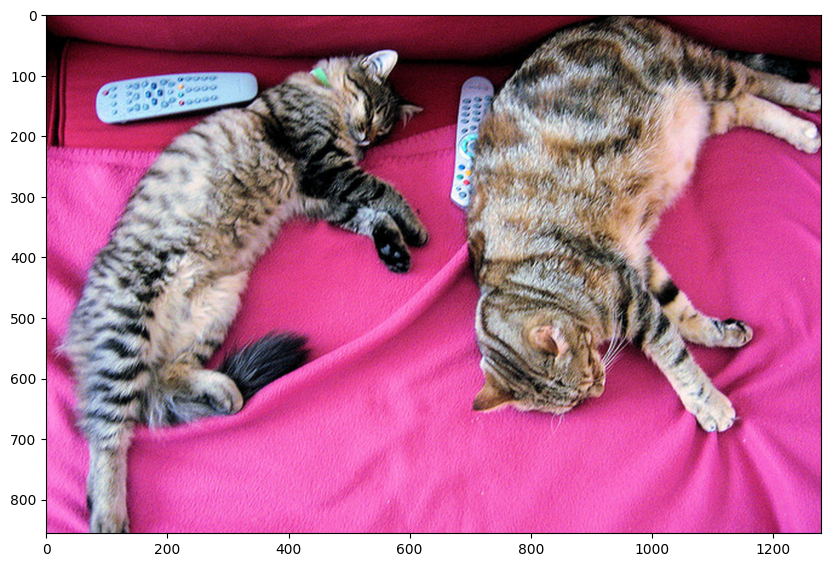

In [ ]:
#### Just run, no revision needed. ####
image_url = "http://images.cocodataset.org/val2017/000000039769.jpg"

downloaded_image_path = download_and_resize_image(image_url, 1280, 856, True)

## 3.5 Ground Truth Visualization

ground truths can be downloaded from
 http://images.cocodataset.org/annotations/annotations_trainval2017.zip

Image downloaded to /tmp/tmp27ij_zjg.jpg.
0.02734375 0.11329166666666667
0.54296875 0.05339583333333333


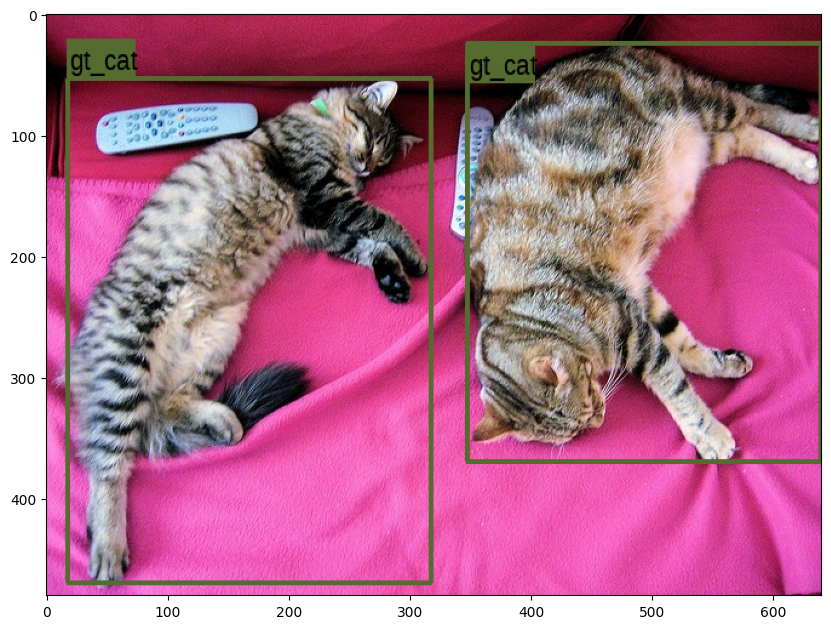

In [ ]:
#### Just run, no revision needed. ####

## ground truths are prepared here
gt_box_cat1 = [17.5, 54.38, 301.25, 415.0]
gt_box_cat2 = [347.5, 25.63, 292.5, 343.75]
image_width = 640
image_height = 480

downloaded_image_path2 = download_and_resize_image(image_url, image_width, image_height, display=False)
image = load_img(downloaded_image_path2)
output_image = draw_boxes_gt(image.numpy(), gt_box_cat1)
output_image = draw_boxes_gt(output_image, gt_box_cat2)
display_image(output_image)


## 3.6 Prediction

In [ ]:
#### Just run, no revision needed. ####
### Download the pre-trained model ###
module_handle = "https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1"

detector = hub.load(module_handle).signatures['default']

Found 100 objects.
Inference time:  0.5056195259094238


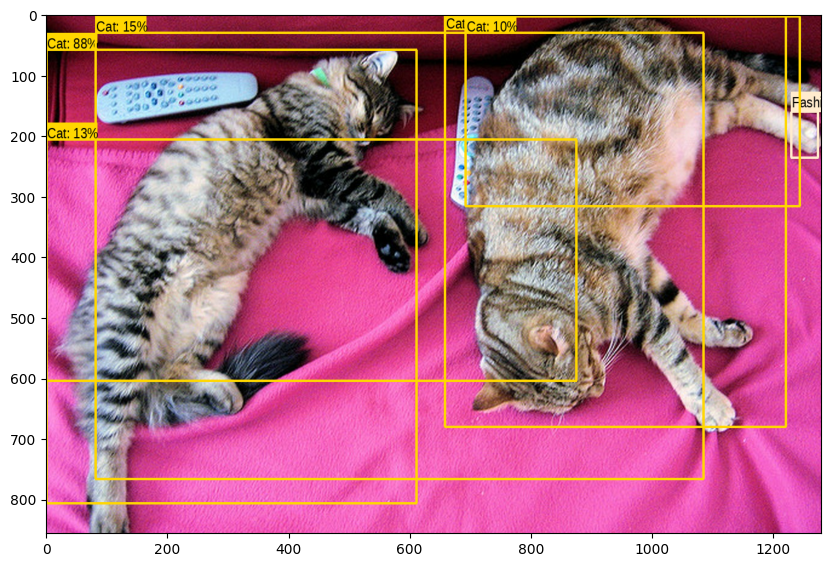

In [ ]:
#### Just run, no revision needed. ####
### Do the prediction ###
predictions = run_detector(detector, downloaded_image_path, display=True)

## 3.7 Evaluation

In [ ]:
# Write the script to calculate IOU
def calculate_iou(box_a, box_b):
  #### YOUR CODE IS HERE ####
  iou = 0


  ###########################
  return iou


def eval(gt_box_list, predictions, conf_threshold, iou_threshold):
  precision = 0
  recall = 0
  detection_boxes = predictions["detection_boxes"]
  detection_class_entities = predictions["detection_class_entities"]
  detection_scores = predictions["detection_scores"]
  # Ensure all three lists are of the same length
  assert len(detection_boxes) == len(detection_class_entities) == len(detection_scores)

  true_positives = 0
  false_positives = 0
  false_negatives = 0
  matched_gt_boxes = []
  # Iterate over the elements
  for pred_box, pred_class, pred_score in zip(detection_boxes, detection_class_entities, detection_scores):
    # print(f"Detection Score: {pred_score}")
    # print(f"Class: {pred_class.decode('utf-8')}")
    # print(f"Detection Box: {pred_box}")
    # print("-----------------------------")


    #### YOUR CODE IS HERE ####
    # Hint: calculate_iou(box1, box2) will be called in this function
    precision = 0
    recall = 0



    ###########################

  return precision, recall




In [ ]:
#### Just run, no revision needed. ####
### Main Function to Predict and Evaluate the Results with Ground Truth ###

## ground truths are prepared here
gt_box_cat1 = [17.5, 54.38, 301.25, 415.0]
gt_box_cat2 = [347.5, 25.63, 292.5, 343.75]

## make it the same format
ymin, xmin, ymax, xmax = convert_box(gt_box_cat1, width=image_width, height=image_height)
gt_box_cat1 = [ymin, xmin, ymax, xmax]
ymin, xmin, ymax, xmax = convert_box(gt_box_cat2, width=image_width, height=image_height)
gt_box_cat2 = [ymin, xmin, ymax, xmax]
gt_box_cat_list = [gt_box_cat1, gt_box_cat2]

## do the prediction
predictions = run_detector(detector, downloaded_image_path, display=False)


## eval
conf_threshold = 0.5
iou_threshold = 0.5
precision, recall = eval(gt_box_list=gt_box_cat_list, predictions=predictions, conf_threshold=conf_threshold, iou_threshold=iou_threshold)
print(f"Confidence Threshold: {conf_threshold:.2f}, IoU Threshold: {iou_threshold:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}")


conf_threshold = 0.5
iou_threshold = 0.8
precision, recall = eval(gt_box_list=gt_box_cat_list, predictions=predictions, conf_threshold=conf_threshold, iou_threshold=iou_threshold)
print(f"Confidence Threshold: {conf_threshold:.2f}, IoU Threshold: {iou_threshold:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}")


conf_threshold = 0.8
iou_threshold = 0.5
precision, recall = eval(gt_box_list=gt_box_cat_list, predictions=predictions, conf_threshold=conf_threshold, iou_threshold=iou_threshold)
print(f"Confidence Threshold: {conf_threshold:.2f}, IoU Threshold: {iou_threshold:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}")


conf_threshold = 0.8
iou_threshold = 0.8
precision, recall = eval(gt_box_list=gt_box_cat_list, predictions=predictions, conf_threshold=conf_threshold, iou_threshold=iou_threshold)
print(f"Confidence Threshold: {conf_threshold:.2f}, IoU Threshold: {iou_threshold:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}")



Found 100 objects.
Inference time:  0.2727477550506592
Confidence Threshold: 0.50, IoU Threshold: 0.50, Precision: 0.00, Recall: 0.00
Confidence Threshold: 0.50, IoU Threshold: 0.80, Precision: 0.00, Recall: 0.00
Confidence Threshold: 0.80, IoU Threshold: 0.50, Precision: 0.00, Recall: 0.00
Confidence Threshold: 0.80, IoU Threshold: 0.80, Precision: 0.00, Recall: 0.00
